In [ ]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.0

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 380.8MB 46kB/s 
     |████████████████████████████████| 3.8MB 43.1MB/s 
     |████████████████████████████████| 450kB 53.2MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 w

In [ ]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

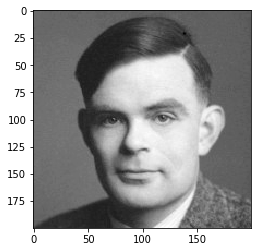

In [ ]:
dist = np.load('distribution.npy')
plt.imshow(dist, cmap='gray')

In [ ]:
nrof_samples=100000
samples = np.random.choice(dist.shape[0]*dist.shape[1], size=nrof_samples, p=dist.flatten())
data = np.asarray([[x//200, x%200] for x in samples])
train = data[:70000]
val = data[70000:80000]
test = data[80000:100000]

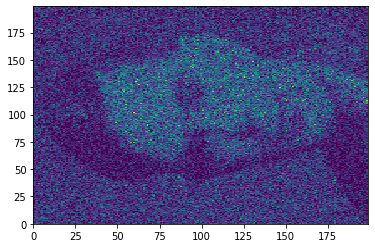

In [ ]:
_ = plt.hist2d(data[:,0], data[:,1], bins=200, range=np.array([[0,199], [0,199]]))

In [ ]:
input_dim, hidden_dim, output_dim=200,200,200

class model(object):
  def __init__(self):
    self.theta_x1 = tf.Variable(tf.zeros(200))
    self.w1 = tf.Variable(tf.random.normal((input_dim,hidden_dim)))
    self.b1 = tf.Variable(tf.zeros(hidden_dim,))
    self.w2 = tf.Variable(tf.random.normal((hidden_dim,output_dim)))
    self.b2 = tf.Variable(tf.zeros(output_dim,))
  
  def call(self,x):
    x1 = tf.one_hot(x,200)
    out1 = tf.matmul(x1,self.w1)+self.b1
    a1  = tf.nn.relu(out1)
    out2 = tf.matmul(a1,self.w2)+self.b2
    out = tf.nn.softmax(out2, axis=-1)
    return out 

  def loss(self, x1, x2):
    th1 = tf.gather(self.theta_x1, x1)
    px1 = tf.math.exp(th1-tf.math.reduce_max(th1))/tf.math.reduce_sum(tf.math.exp(self.theta_x1-tf.math.reduce_max(th1)))
    loss1  = tf.math.reduce_mean(-tf.math.log(px1))
    out = self.call(x1)
    px2_x1  = tf.gather_nd(out, tf.stack([tf.range(len(x1)),x2],axis=1))
    loss2 = tf.math.reduce_mean(-tf.math.log(px2_x1))
    loss = (loss1+loss2)/tf.math.log(2.)
    final_p = px1 * px2_x1
    return loss, final_p

batch_size=1000
lr=1e-3

mlp = model()
v = [mlp.w1,mlp.b1,mlp.w2,mlp.b2, mlp.theta_x1]
opt = tf.optimizers.Adam(learning_rate=lr)

trn_loss, val_loss = [],[]
for i in range(10000):
  batch_loss =[]
  idx = np.random.choice(tf.range(tf.shape(train)[0]), size= batch_size)
  batch = train[idx]
  with tf.device(device):
    with tf.GradientTape() as g:
      loss, _ = mlp.loss(batch[:,0], batch[:,1])
    batch_loss.append(loss)
    grads = g.gradient(loss, v)
    grads_and_vars = zip(grads, v)
    opt.apply_gradients(grads_and_vars)

    if  i % 100 == 0:
      trn_loss.append(tf.math.reduce_mean(loss))
      vloss,_ = mlp.loss(val[:,0], val[:,1])
      val_loss.append(vloss)
      print('step: {}  Train loss: {}  Validation Loss: {}'.format(i, trn_loss[-1], val_loss[-1]))
  

step: 0  Train loss: 46.23682403564453  Validation Loss: 46.22064208984375
step: 100  Train loss: 32.4031867980957  Validation Loss: 32.78727340698242
step: 200  Train loss: 27.99895477294922  Validation Loss: 28.1328182220459
step: 300  Train loss: 25.120317459106445  Validation Loss: 25.474498748779297
step: 400  Train loss: 23.417835235595703  Validation Loss: 23.634185791015625
step: 500  Train loss: 21.978137969970703  Validation Loss: 22.245882034301758
step: 600  Train loss: 20.8813533782959  Validation Loss: 21.159664154052734
step: 700  Train loss: 19.810161590576172  Validation Loss: 20.296995162963867
step: 800  Train loss: 19.08830451965332  Validation Loss: 19.590463638305664
step: 900  Train loss: 18.30135154724121  Validation Loss: 19.008621215820312
step: 1000  Train loss: 18.386486053466797  Validation Loss: 18.518321990966797
step: 1100  Train loss: 17.71677017211914  Validation Loss: 18.106908798217773
step: 1200  Train loss: 17.193359375  Validation Loss: 17.7555522

In [ ]:
tloss, _=mlp.loss(test[:,0],test[:,1])
print('Test Loss: ', tloss)

Test Loss:  tf.Tensor(15.513729, shape=(), dtype=float32)


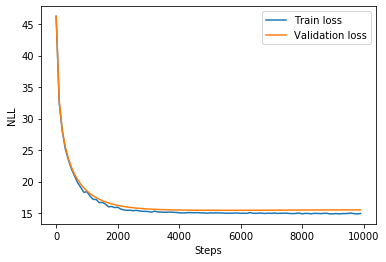

In [ ]:
plt.plot(range(0,10000,100), trn_loss, label='Train loss')
plt.plot(range(0,10000,100), val_loss, label='Validation loss')
plt.xlabel('Steps')
plt.ylabel('NLL')
plt.legend()

In [ ]:
all_datapoints = tf.convert_to_tensor(([(x,y) for x in range(200) for y in range(200)]))
_, final_p = mlp.loss(all_datapoints[:,0],all_datapoints[:,1])
px = tf.reshape(final_p,(200,200))

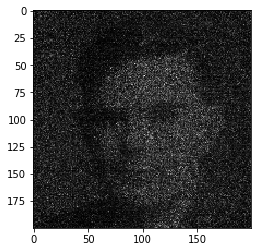

In [ ]:
plt.imshow(px,cmap='gray')

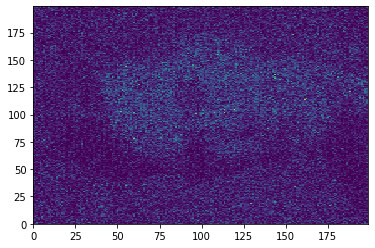

In [ ]:
final_p = tf.cast(final_p, tf.float64)
final_p = tf.truediv(final_p, tf.reduce_sum(final_p, axis=-1))
test_samples = np.random.choice(200**2, 100000, p=final_p)
x =np.asarray([( x//200, x%200) for x in test_samples])
_ = plt.hist2d(x[:,0], x[:,1], bins=200, range=np.array([[0,199], [0,199]]))

In [ ]:
class made(object):
  def __init__(self, nrof_dims=2, nrof_units=200, nrof_layers=2, nrof_bins=200 ):
    self.nrof_dims = nrof_dims
    self.nrof_units = nrof_units
    self.nrof_layers = nrof_layers
    self.nrof_bins = nrof_bins
    self.idx = 0

    self.params = []
    inp_dims = nrof_dims*nrof_bins
    for i in range(self.nrof_layers):
       self.params.append(tf.Variable(tf.random.normal((inp_dims,nrof_units))*0.001))
       self.params.append(tf.Variable(tf.zeros((nrof_units,))))
       inp_dims = nrof_units
    self.params.append(tf.Variable(tf.random.normal((nrof_units,nrof_dims*nrof_bins))*0.001))
    self.params.append(tf.Variable(tf.zeros((nrof_dims*nrof_bins,))))
      
      
  def get_masks(self):
    seed = 666
    np.random.seed(seed)        
        
    m = []
    m += [ np.repeat(np.arange(self.nrof_dims), self.nrof_bins) ]
    for i in range(self.nrof_layers):
        m += [ np.random.randint((m[-1]).min(), self.nrof_dims, [self.nrof_units]) ]

    mask = []
    for i in range(self.nrof_layers):
        mask += [ m[i+1][:,None] >= m[i][None,:] ]

    mask += [ m[0][:,None] > m[-1][None,:] ]
    return mask
  
  def forward(self, x):
    x = tf.reshape(tf.cast(tf.one_hot(x, self.nrof_bins), tf.float32) ,(-1, self.nrof_dims*self.nrof_bins))
    mask = self.get_masks()
    for i in range(self.nrof_layers):
      x = tf.tensordot(x,self.params[self.idx]*mask[i].T, 1)+self.params[self.idx+1]
      x = tf.nn.dropout(x, rate=0.2)
      x = tf.nn.relu(x)
      self.idx+=2
    x = tf.tensordot(x,self.params[self.idx]*mask[i+1].T, 1)+self.params[self.idx+1]   
    p = tf.nn.softmax(tf.reshape(x, (-1, self.nrof_dims, self.nrof_bins)), axis=-1)
    self.idx=0
    return p
  
  def loss(self,X):
    x = self.forward(X)
    out1, out2 = tf.unstack(x,axis=1)
    x1, x2 = tf.unstack(X,axis=1)
    idx1 = tf.stack([np.arange(out1.shape[0]), x1], axis=1)
    idx2 = tf.stack([np.arange(out2.shape[0]), x2], axis=1)
    px1 = tf.gather_nd(out1, idx1)
    px2 = tf.gather_nd(out2, idx2)
    loss = tf.math.reduce_mean(-tf.math.log(px1+1e-15)-tf.math.log(px2+1e-15))/tf.math.log(2.)
    p = px1*px2
    return loss,p


In [ ]:
batch_size=10000
lr=1e-3
num_epochs = 250
print_every = 50

m = made()
mopt = tf.optimizers.Adam(learning_rate=lr)

mtrn_loss, mval_loss = [],[]
for i in range(num_epochs):
  batch_loss=[]
  for batch in np.array_split(train, train.shape[0]//batch_size ) :
    with tf.device(device):
      with tf.GradientTape() as g:
        loss, _ = m.loss(batch)
      batch_loss.append(loss)
      grads = g.gradient(loss, m.params)
      grads_and_vars = zip(grads, m.params)
      mopt.apply_gradients(grads_and_vars)

  if  i % print_every == 0:
    mtrn_loss.append(tf.math.reduce_mean(batch_loss))
    mvloss,_ = m.loss(val)
    mval_loss.append(tf.math.reduce_mean(mvloss))
    print('Epoch: {}  Train loss: {}  Validation Loss: {}'.format(i, mtrn_loss[-1], mval_loss[-1]))
  

Epoch: 0  Train loss: 15.286405563354492  Validation Loss: 15.284655570983887
Epoch: 50  Train loss: 15.2044095993042  Validation Loss: 15.221670150756836
Epoch: 100  Train loss: 15.20034122467041  Validation Loss: 15.219958305358887
Epoch: 150  Train loss: 15.18563175201416  Validation Loss: 15.220182418823242
Epoch: 200  Train loss: 15.155487060546875  Validation Loss: 15.232765197753906


In [ ]:
mtloss, p=m.loss(test)
print('Test Loss: ', mtloss)

Test Loss:  tf.Tensor(15.2506275, shape=(), dtype=float32)


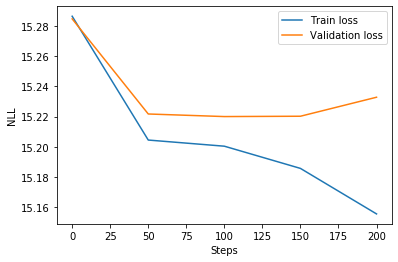

In [ ]:
plt.plot(range(0, num_epochs, print_every), mtrn_loss, label='Train loss')
plt.plot(range(0, num_epochs, print_every), mval_loss, label='Validation loss')
plt.xlabel('Steps')
plt.ylabel('NLL')
plt.legend()

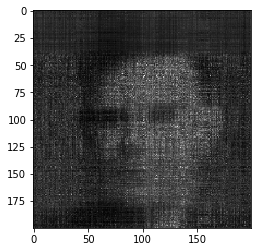

In [ ]:
all_datapoints = tf.convert_to_tensor(([(x,y) for x in range(200) for y in range(200)]))
_, mfinal_p = m.loss(all_datapoints)
mpx = tf.reshape(mfinal_p,(200,200))
plt.imshow(mpx,cmap='gray')